# Data

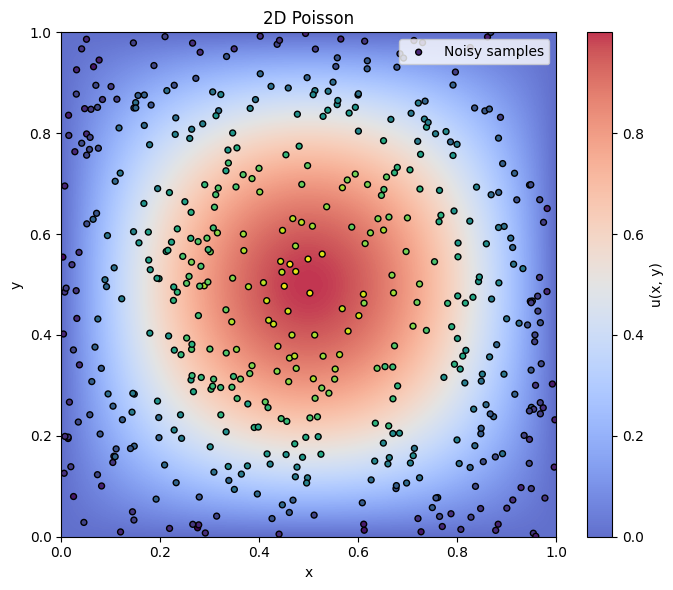

In [7]:
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
torch.set_num_threads(4)

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# CP
from utils_uqmd.utils_uq_cp import CP

# Ensure reproducibility
import random, numpy as np, torch
seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Data Noise
data_noise = 0.05

# Define PDE
domain=((0.0, 1.0), (0.0, 1.0))
true_solution=lambda xy: torch.sin(math.pi * xy[..., 0:1]) * torch.sin(math.pi * xy[..., 1:2])
pde = Poisson2D(domain, true_solution)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(500, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(50, data_noise)
(X_validation, Y_validation) = pde.data_generation(100, data_noise)

# Number of colocation point
colloc_pt_num = 100

# Generating alphas to test
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(20)

alpha = 0.95

# --------------------------------------------
# Defining Testing
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────
from utils_tools.utils_result_viz import plot_truth_and_samples_2D

# Dense grid for nice plotting
def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

grid_plot, X_mesh, Y_mesh = make_dense_grid(domain, 200)
grid_test_torch = torch.tensor(grid_plot, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


plot_truth_and_samples_2D(
    X_train, Y_train, grid_plot, U_true_grid, domain,
    title="2D Poisson"
)


# Feature Distance Model

## Define Model

In [23]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}

baseline_pred_kwargs = dict(n_samples=200)


# CP-Model

cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"feature", # Change base on if the baseline cp
    "k":10
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":"feature",
    "n_samples":10, 
}

dist_feat_pinn = DistanceUQPINN(**model_args)

## Training Base Model

In [24]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_feat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_feat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=10, 
    heuristic_u="feature"
)
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=1.02e+02 | lr=1.0e-03
ep   500 | L=5.86e-01 | lr=1.0e-03
ep  1000 | L=4.36e-01 | lr=1.0e-03
ep  1500 | L=2.82e-01 | lr=1.0e-03
ep  2000 | L=2.40e-01 | lr=1.0e-03
ep  2500 | L=1.91e-01 | lr=1.0e-03
ep  3000 | L=1.86e-01 | lr=1.0e-03
ep  3500 | L=1.51e-01 | lr=1.0e-03
ep  4000 | L=1.36e-01 | lr=1.0e-03
ep  4500 | L=1.02e-01 | lr=1.0e-03
ep  5000 | L=8.81e-02 | lr=1.0e-03


## Create CP Model

In [25]:
# CP Model
dist_feat_pinn_cp = CP(dist_feat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"feature",  # Change this based on cp
        "k":10
}

dist_feat_pinn_cp_cal_predset = dist_feat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dist_feat_pinn_df_uncal = dist_test_uncertainties(uqmodel=dist_feat_pinn, **baseline_testing_args)
dist_feat_pinndf_cal = cp_test_uncertainties(dist_feat_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_Poisson", prefix="feature_distance",
    loss=baseline_data_loss
)(
    grid_test, dist_feat_pinn_uncal_predset, dist_feat_pinn_cp_cal_predset, 
    true_solution, 
    dist_feat_pinn_df_uncal, dist_feat_pinndf_cal,
    title="2D UQ", main_title="Feature Distance Model", 
    X_vis=X_train, Y_vis=Y_train
)


save_plot(
    plot_metrics_table,
    save_dir="2D_Poisson", prefix="feature_distance_table",
    loss=baseline_data_loss
)(
    grid_test, dist_feat_pinn_uncal_predset, dist_feat_pinn_cp_cal_predset, 
    true_solution, 
    dist_feat_pinn_df_uncal, dist_feat_pinndf_cal,
    title="2D UQ", main_title="Feature Distance Model", 
    X_vis=X_train, Y_vis=Y_train
)

100%|██████████| 19/19 [00:00<00:00, 428.52it/s]


<Figure size 640x480 with 0 Axes>

# Latent Distance Model

## Define Model

In [27]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}


# CP-Model

cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"latent", # Change base on if the baseline cp
    "k":10
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":"latent",
    "n_samples":10, 
}

dist_lat_pinn = DistanceUQPINN(**model_args)

## Training Base Model

In [28]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_lat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_lat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=10, 
    heuristic_u="latent"
)
dist_lat_pinn_uncal_predset = dist_lat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=8.70e+01 | lr=1.0e-03
ep   500 | L=2.75e-01 | lr=1.0e-03
ep  1000 | L=1.94e-01 | lr=1.0e-03
ep  1500 | L=2.11e-01 | lr=1.0e-03
ep  2000 | L=1.08e-01 | lr=1.0e-03
ep  2500 | L=1.08e-01 | lr=1.0e-03
ep  3000 | L=8.58e-02 | lr=1.0e-03
ep  3500 | L=8.20e-02 | lr=1.0e-03
ep  4000 | L=6.42e-02 | lr=1.0e-03
ep  4500 | L=3.30e-02 | lr=1.0e-03
ep  5000 | L=3.98e-02 | lr=1.0e-03


## Create CP Model

In [29]:
# CP Model
dist_lat_pinn_cp = CP(dist_lat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"latent",  # Change this based on cp
        "k":10
}

dist_lat_pinn_cp_cal_predset = dist_lat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dist_lat_pinn_df_uncal = dist_test_uncertainties(uqmodel=dist_lat_pinn, **baseline_testing_args)
dist_lat_pinn_df_cal = cp_test_uncertainties(dist_lat_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_Poisson", prefix="latent_distance",
    loss=baseline_data_loss
)(
    grid_test, dist_lat_pinn_uncal_predset, dist_lat_pinn_cp_cal_predset, 
    true_solution, 
    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal,
    title="2D UQ", main_title="Latent Distance Model", 
    X_vis=X_train, Y_vis=Y_train
)

save_plot(
    plot_metrics_table,
    save_dir="2D_Poisson", prefix="latent_distance_table",
    loss=baseline_data_loss
)(
    grid_test, dist_lat_pinn_uncal_predset, dist_lat_pinn_cp_cal_predset, 
    true_solution, 
    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal,
    title="2D UQ", main_title="Latent Distance Model", 
    X_vis=X_train, Y_vis=Y_train
)

100%|██████████| 19/19 [00:00<00:00, 292.24it/s]


<Figure size 640x480 with 0 Axes>

# Dropout Model

## Define Model

In [31]:
from utils_uqmd.utils_uq_dropout import DropoutPINN

# Base Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}
baseline_pred_kwargs = {  
    "n_samples":20 
}

# CP Model
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline cp
    "k":10
}

cp_pred_kwargs = {
    "X_train":X_train,  "Y_train":Y_train,
    "X_cal":X_calibration, "Y_cal":Y_calibration,
    "heuristic_u":"raw_std",
    "k":10
}

baseline_testing_args = { 
    # "uqmodel":do_pinn,   # Change this
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "n_samples":20
}

dropout_pinn = DropoutPINN(**model_args)

## Training Base Model

In [32]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dropout_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dropout_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=20
)
dropout_pinn_uncal_predset = dropout_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=1.00e+02 | data=4.23e-01 | pde=9.93e+01  ic=0.00e+00  bc=3.06e-02 | lr=1.00e-03
ep   500 | L=1.00e+01 | data=1.05e-01 | pde=8.48e+00  ic=0.00e+00  bc=1.42e-01 | lr=1.00e-03
ep  1000 | L=9.62e+00 | data=8.45e-02 | pde=8.39e+00  ic=0.00e+00  bc=1.15e-01 | lr=1.00e-03
ep  1500 | L=8.55e+00 | data=8.85e-02 | pde=7.34e+00  ic=0.00e+00  bc=1.12e-01 | lr=1.00e-03
ep  2000 | L=7.77e+00 | data=7.32e-02 | pde=6.58e+00  ic=0.00e+00  bc=1.12e-01 | lr=1.00e-03
ep  2500 | L=6.29e+00 | data=7.30e-02 | pde=4.99e+00  ic=0.00e+00  bc=1.23e-01 | lr=1.00e-03
ep  3000 | L=5.72e+00 | data=7.74e-02 | pde=4.55e+00  ic=0.00e+00  bc=1.09e-01 | lr=1.00e-03
ep  3500 | L=5.48e+00 | data=7.86e-02 | pde=4.40e+00  ic=0.00e+00  bc=1.00e-01 | lr=1.00e-03
ep  4000 | L=4.76e+00 | data=7.43e-02 | pde=3.73e+00  ic=0.00e+00  bc=9.50e-02 | lr=1.00e-03
ep  4500 | L=3.97e+00 | data=1.00e-01 | pde=2.70e+00  ic=0.00e+00  bc=1.16e-01 | lr=1.00e-03
ep  5000 | L=4.53e+00 | data=8.91e-02 | pde=3.36e+00  ic=0.00e+00  bc=

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


## Create CP Model

In [33]:
# CP Model
dropout_pinn_cp = CP(dropout_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",  # Change this based on cp
        "k":10
}

dropout_pinn_cp_cal_predset = dropout_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dropout_pinn_df_uncal = do_test_uncertainties(uqmodel=dropout_pinn, **baseline_testing_args)
dropout_pinn_df_cal = cp_test_uncertainties(dropout_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_Poisson", prefix="dropout",
    loss=baseline_data_loss
)(
    grid_test, dropout_pinn_uncal_predset, dropout_pinn_cp_cal_predset, 
    true_solution, 
    dropout_pinn_df_uncal, dropout_pinn_df_cal,
    title="2D UQ", main_title="Dropout Model", 
    X_vis=X_train, Y_vis=Y_train
)


save_plot(
    plot_metrics_table,
    save_dir="2D_Poisson", prefix="dropout_table",
    loss=baseline_data_loss
)(
    grid_test, dropout_pinn_uncal_predset, dropout_pinn_cp_cal_predset, 
    true_solution, 
    dropout_pinn_df_uncal, dropout_pinn_df_cal,
    title="2D UQ", main_title="Dropout Model", 
    X_vis=X_train, Y_vis=Y_train
)

100%|██████████| 19/19 [00:01<00:00, 15.15it/s]


<Figure size 640x480 with 0 Axes>

# VI Model

## Define Model

In [35]:
from utils_uqmd.utils_uq_vi import VIBPINN

# Base Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
    "mu_std" : 0.01, "rho" : -5, "prior_std" : 1.0, 
    "init_data_noise" : 1.0, "learn_data_noise" : False, 
    "act_func" : nn.Tanh()
}

baseline_testing_args = { 
    # "uqmodel":vi_model, 
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test
}

vi_bpinn = VIBPINN(**model_args)

## Training Base Model

In [ ]:
# Base Model
# Training
fit_args = {
    "coloc_pt_num":colloc_pt_num,
    "X_train":X_train, 
    "Y_train":Y_train
}
fit_kwargs_grid = {
    "epochs":15000,
    "λ_pde":5.0, "λ_bc":5.0, "λ_elbo":1.0,  
    "lr":3e-3,
    "stop_schedule":20000
}
baseline_loss_dict = vi_bpinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = vi_bpinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=5000
)
vi_bpinn_uncal_predset = vi_bpinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     0 | L=4.74e+04 | elbo=1.66e+02 | pde=9.44e+03  ic=0.00e+00  bc=1.87e-04 | lr=3.00e-03 | learned noise_std=1.000e+00
ep     1 | L=3.75e+04 | elbo=1.66e+02 | pde=7.46e+03  ic=0.00e+00  bc=5.09e-08 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   300 | L=3.33e+03 | elbo=8.80e+02 | pde=4.85e+02  ic=0.00e+00  bc=5.24e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   600 | L=2.97e+03 | elbo=6.70e+02 | pde=4.55e+02  ic=0.00e+00  bc=4.76e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   900 | L=3.05e+03 | elbo=6.05e+02 | pde=4.84e+02  ic=0.00e+00  bc=3.96e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  1200 | L=3.52e+03 | elbo=6.67e+02 | pde=5.65e+02  ic=0.00e+00  bc=4.67e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  1500 | L=3.02e+03 | elbo=6.78e+02 | pde=4.64e+02  ic=0.00e+00  bc=4.75e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  1800 | L=3.04e+03 | elbo=7.98e+02 | pde=4.43e+02  ic=0.00e+00  bc=5.21e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  2100 | L=5.3

## Create CP Model

In [37]:
# CP Model
vi_bpinn_cp = CP(vi_bpinn)

# CP
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",
        "k":10
}

cp_testing_args = {
        "alphas":alphas, 
        "X_test":X_test, "Y_test":Y_test, 
        "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
        "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
        "k":10
}

vi_bpinn_cp_cal_predset = vi_bpinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
vi_bpinn_df_uncal = vi_test_uncertainties(uqmodel=vi_bpinn, **baseline_testing_args)
vi_bpinn_df_cal = cp_test_uncertainties(vi_bpinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_Poisson", prefix="vi_bpinn",
    loss=baseline_data_loss
)(
    grid_test, vi_bpinn_uncal_predset, vi_bpinn_cp_cal_predset, 
    true_solution, 
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    title="2D UQ", main_title="VI Model", 
    X_vis=X_train, Y_vis=Y_train
)


save_plot(
    plot_metrics_table,
    save_dir="2D_Poisson", prefix="vi_bpinn_table",
    loss=baseline_data_loss
)(
    grid_test, vi_bpinn_uncal_predset, vi_bpinn_cp_cal_predset, 
    true_solution, 
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    title="2D UQ", main_title="VI Model", 
    X_vis=X_train, Y_vis=Y_train
)

100%|██████████| 19/19 [07:22<00:00, 23.30s/it]


<Figure size 640x480 with 0 Axes>

# HMC Model

## Define Model

In [5]:
from utils_uqmd.utils_uq_hmc import HMCBPINN

# Base Model Instance
model_args = dict(
    pde_class=pde,input_dim=2, hidden_dims=[16, 32, 64, 64, 64, 32, 16],
    output_dim=1, act_func=nn.Tanh, prior_std=1.0,
    step_size=1e-3, leapfrog_steps=5
)

baseline_testing_args = {
    # "uqmodel": hmc_model,
    "alphas": alphas,
    "X_test": X_test,
    "Y_test": Y_test,
    "n_samples": 5000
}



hmc_bpinn = HMCBPINN(**model_args)

## Training Base Model

In [ ]:
# Base Model
# Training
fit_args = {
    "coloc_pt_num":colloc_pt_num,
    "X_train":X_train, 
    "Y_train":Y_train
}
fit_kwargs_grid = {
    "λ_pde": 3.0,
    "λ_bc": 5.0,
    "λ_data": 1.0,
    "epochs": 5000,
    "lr":1e-3,
    "hmc_samples": 12000,
    "brun_in":5000,
    "step_size": 5e-4,
    "leapfrog_steps": 14,
    "lr_decay_step":2000
}
baseline_loss_dict = hmc_bpinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = hmc_bpinn.data_loss(X_validation, Y_validation)


# Predict 
baseline_pred_kwargs = { "n_samples": 5000 }
hmc_bpinn_uncal_predset = hmc_bpinn.predict(
            alpha=alpha, X_test=grid_test,
            **baseline_pred_kwargs
        )

MAP:  11%|█         | 531/5000 [00:03<00:23, 187.56it/s, loss=2.52e+01]

[MAP] epoch    500 −logPost=2.712e+01  Data=7.12e-01  PDE=1.13e+01  IC=0.00e+00  BC=1.53e+00


MAP:  21%|██        | 1027/5000 [00:05<00:20, 190.05it/s, loss=2.21e+01]

[MAP] epoch   1000 −logPost=2.204e+01  Data=7.30e-01  PDE=7.25e+00  IC=0.00e+00  BC=1.61e+00


MAP:  31%|███       | 1534/5000 [00:08<00:18, 188.62it/s, loss=1.89e+01]

[MAP] epoch   1500 −logPost=2.078e+01  Data=6.69e-01  PDE=6.63e+00  IC=0.00e+00  BC=1.43e+00


MAP:  41%|████      | 2026/5000 [00:10<00:15, 191.64it/s, loss=1.37e+01]

[MAP] epoch   2000 −logPost=1.368e+01  Data=3.97e-02  PDE=8.20e-01  IC=0.00e+00  BC=7.18e-02


MAP:  51%|█████     | 2526/5000 [00:13<00:12, 191.95it/s, loss=1.28e+01]

[MAP] epoch   2500 −logPost=1.291e+01  Data=3.06e-02  PDE=5.91e-01  IC=0.00e+00  BC=5.06e-02


MAP:  61%|██████    | 3028/5000 [00:16<00:11, 171.31it/s, loss=1.22e+01]

[MAP] epoch   3000 −logPost=1.221e+01  Data=2.08e-02  PDE=2.66e-01  IC=0.00e+00  BC=4.03e-02


MAP:  71%|███████   | 3531/5000 [00:19<00:07, 197.28it/s, loss=1.18e+01]

[MAP] epoch   3500 −logPost=1.188e+01  Data=2.07e-02  PDE=2.61e-01  IC=0.00e+00  BC=3.87e-02


MAP:  80%|████████  | 4021/5000 [00:21<00:05, 176.43it/s, loss=1.16e+01]

[MAP] epoch   4000 −logPost=1.157e+01  Data=1.68e-02  PDE=2.44e-01  IC=0.00e+00  BC=3.53e-02


MAP:  91%|█████████ | 4531/5000 [00:24<00:02, 181.36it/s, loss=1.15e+01]

[MAP] epoch   4500 −logPost=1.151e+01  Data=2.03e-02  PDE=2.79e-01  IC=0.00e+00  BC=4.02e-02


[MAP] epoch   5000 −logPost=1.129e+01  Data=1.96e-02  PDE=2.01e-01  IC=0.00e+00  BC=3.88e-02


HMC:   4%|▍         | 502/12000 [00:29<10:46, 17.78it/s, acc=0.71]

[HMC] iter    500  acc-rate=0.71


HMC:   8%|▊         | 1002/12000 [00:57<10:29, 17.48it/s, acc=0.69]

[HMC] iter   1000  acc-rate=0.69


HMC:  13%|█▎        | 1502/12000 [01:25<09:52, 17.70it/s, acc=0.68]

[HMC] iter   1500  acc-rate=0.68


HMC:  17%|█▋        | 2002/12000 [01:53<09:41, 17.19it/s, acc=0.67]

[HMC] iter   2000  acc-rate=0.67


HMC:  21%|██        | 2502/12000 [02:21<08:52, 17.85it/s, acc=0.66]

[HMC] iter   2500  acc-rate=0.66


HMC:  25%|██▌       | 3002/12000 [02:50<08:19, 18.03it/s, acc=0.64]

[HMC] iter   3000  acc-rate=0.64


HMC:  29%|██▉       | 3502/12000 [03:18<08:02, 17.62it/s, acc=0.64]

[HMC] iter   3500  acc-rate=0.64


HMC:  33%|███▎      | 4002/12000 [03:46<07:25, 17.93it/s, acc=0.64]

[HMC] iter   4000  acc-rate=0.64


HMC:  38%|███▊      | 4502/12000 [04:14<07:24, 16.88it/s, acc=0.63]

[HMC] iter   4500  acc-rate=0.63


HMC:  42%|████▏     | 5002/12000 [04:42<05:58, 19.53it/s, acc=0.63]

[HMC] iter   5000  acc-rate=0.63


HMC:  46%|████▌     | 5502/12000 [05:09<05:33, 19.47it/s, acc=0.62]

[HMC] iter   5500  acc-rate=0.62


HMC:  50%|█████     | 6002/12000 [05:35<05:36, 17.84it/s, acc=0.63]

[HMC] iter   6000  acc-rate=0.63


HMC:  54%|█████▍    | 6502/12000 [06:01<04:41, 19.53it/s, acc=0.62]

[HMC] iter   6500  acc-rate=0.62


HMC:  58%|█████▊    | 7002/12000 [06:27<04:13, 19.71it/s, acc=0.62]

[HMC] iter   7000  acc-rate=0.62


HMC:  63%|██████▎   | 7502/12000 [06:52<03:50, 19.52it/s, acc=0.62]

[HMC] iter   7500  acc-rate=0.62


HMC:  67%|██████▋   | 8002/12000 [07:18<03:24, 19.52it/s, acc=0.62]

[HMC] iter   8000  acc-rate=0.62


HMC:  71%|███████   | 8502/12000 [07:44<03:36, 16.19it/s, acc=0.61]

[HMC] iter   8500  acc-rate=0.61


HMC:  75%|███████▌  | 9002/12000 [08:10<02:37, 19.05it/s, acc=0.61]

[HMC] iter   9000  acc-rate=0.61


HMC:  79%|███████▉  | 9502/12000 [08:36<02:09, 19.29it/s, acc=0.61]

[HMC] iter   9500  acc-rate=0.61


HMC:  83%|████████▎ | 10002/12000 [09:03<01:51, 17.90it/s, acc=0.61]

[HMC] iter  10000  acc-rate=0.61


HMC:  88%|████████▊ | 10502/12000 [09:30<01:29, 16.73it/s, acc=0.61]

[HMC] iter  10500  acc-rate=0.61


HMC:  92%|█████████▏| 11002/12000 [09:57<00:52, 18.88it/s, acc=0.61]

[HMC] iter  11000  acc-rate=0.61


HMC:  96%|█████████▌| 11501/12000 [10:23<00:25, 19.57it/s, acc=0.60]

[HMC] iter  11500  acc-rate=0.60


[HMC] iter  12000  acc-rate=0.60
Finished HMC: avg acceptance 0.601
Kept 11500 posterior samples


## Create CP Model

In [8]:
# CP Model
hmc_bpinn_cp = CP(hmc_bpinn)

# CP
cp_pred_kwargs = { 
    "X_train": X_train, "Y_train": Y_train,
    "X_cal": X_calibration, "Y_cal": Y_calibration,
    "heuristic_u": "raw_std", "k": 10
}

cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
    "k":10
}

hmc_bpinn_cp_cal_predset = hmc_bpinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import hmc_test_uncertainties, cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
hmc_bpinn_df_uncal = hmc_test_uncertainties(uqmodel=hmc_bpinn, **baseline_testing_args)
hmc_bpinn_df_cal = cp_test_uncertainties(hmc_bpinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_Poisson", prefix="hmc_bpinn",
    loss=baseline_data_loss
)(
    grid_test, hmc_bpinn_uncal_predset, hmc_bpinn_cp_cal_predset, 
    true_solution, 
    hmc_bpinn_df_uncal, hmc_bpinn_df_cal,
    title="2D UQ", main_title="HMC Model", 
    X_vis=X_train, Y_vis=Y_train
)

save_plot(
    plot_metrics_table,
    save_dir="2D_Poisson", prefix="hmc_bpinn_table",
    loss=baseline_data_loss
)(
    grid_test, hmc_bpinn_uncal_predset, hmc_bpinn_cp_cal_predset, 
    true_solution, 
    hmc_bpinn_df_uncal, hmc_bpinn_df_cal,
    title="2D UQ", main_title="HMC Model", 
    X_vis=X_train, Y_vis=Y_train
)

  0%|          | 0/19 [00:00<?, ?it/s]/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 19/19 [00:55<00:00,  2.92s/it]


<Figure size 640x480 with 0 Axes>